# Mapping Pollution in Colorado in 2019

* ** no2, so2, co, o3, and pm25**
* **https://openaq.org**


*Step 1: Import Python modules and define helper functions*

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import folium
import folium.plugins as plugins
from IPython.core import display as ICD
from google.cloud import bigquery
from bq_helper import BigQueryHelper
import pycountry
import os
import plotly
import plotly.offline as py
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as fig_fact
plotly.tools.set_config_file(world_readable=True, sharing='public')
from mpl_toolkits.basemap import Basemap
from matplotlib import animation,rc
import io
import base64
from IPython.display import HTML, display
import warnings
warnings.filterwarnings('ignore')

def folium_map(df, center_lat, center_lon, zoom) :
    # Adapted from https://www.kaggle.com/dejavu23/openaq-from-queries-to-world-maps
    m = folium.Map(location=[center_lat, center_lon],
                   zoom_start = zoom)
    for index, row in df.iterrows():
        folium.CircleMarker( [row['latitude'], row['longitude']] , radius=20, 
                             color=custom_colormap(row['value']), 
                             fill=False, fill_opacity=0,            
                             fill_color=custom_colormap(row['value']), 
                             popup=row['city'] ).add_to(m)
    custom_colormap.add_to(m)
    folium.TileLayer(tiles='Stamen Toner',name="Stamen Toner").add_to(m)
    folium.TileLayer(tiles='Stamen Terrain',name="Stamen Terrain").add_to(m)
    folium.TileLayer(tiles='cartodbpositron',name="cartodbpositron").add_to(m)
    folium.LayerControl().add_to(m)    
    return m

def animate(Year):
    # adapted from from https://www.kaggle.com/piumallick/air-pollution-analysis-on-air-quality-index
    ax = plt.axes()
    ax.clear()
    ax.set_title('NO2 Levels in Year: '+str(Year))
    m4 = Basemap(llcrnrlon=-125,llcrnrlat=25,urcrnrlon=-65,urcrnrlat=50, #-110,38,-100,45 for Colorado
        projection='cyl',lat_1=33,lat_2=45,lon_0=-95)
    m4.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
    m4.fillcontinents(color='grey', alpha=0.3)
    m4.drawcoastlines(linewidth=0.1, color="white")
    m4.shadedrelief()
    lat_y = list(OpenAQ[OpenAQ['Year'] == Year]['latitude'])
    lon_y = list(OpenAQ[OpenAQ['Year'] == Year]['longitude'])
    lat,lon = m4(lat_y,lon_y) 
    avg = np.log(OpenAQ[OpenAQ['Year'] == Year]['Average'])
    m4.scatter(lon,lat,c = avg,lw=10, alpha=0.3,cmap='hot_r')

*Step 2: Write queries for pollution levels*

In [2]:
def query_all_1pollutant_1country(pollutant, country) :
    # Adapted from https://www.kaggle.com/dejavu23/openaq-from-queries-to-world-maps
    s = "SELECT *"
    f = " FROM `bigquery-public-data.openaq.global_air_quality` as globalAQ"
    w = " WHERE pollutant = '" + pollutant + "'" + \
        " AND value > 0" + " AND country = '" + country + "'" + \
        " AND EXTRACT(YEAR FROM globalAQ.timestamp) > 2018"        
    q = s+f+w
    return q

no2_over_time = """
            SELECT EXTRACT(YEAR FROM timestamp) as `Year`,
                   AVG(value) as `Average`,
                   latitude,
                   longitude,
                   country
        FROM `bigquery-public-data.openaq.global_air_quality`
        WHERE EXTRACT(YEAR FROM timestamp) > 2010        
        AND pollutant = 'no2'
        AND country = 'US'
        GROUP BY Year, 
                 latitude,
                 longitude,
                 country
        """
open_aq = BigQueryHelper(active_project="bigquery-public-data",dataset_name="openaq")

Using Kaggle's public dataset BigQuery integration.


*Step 3: Animated map of reported NO2 emissions in the USA (2010-2010)*


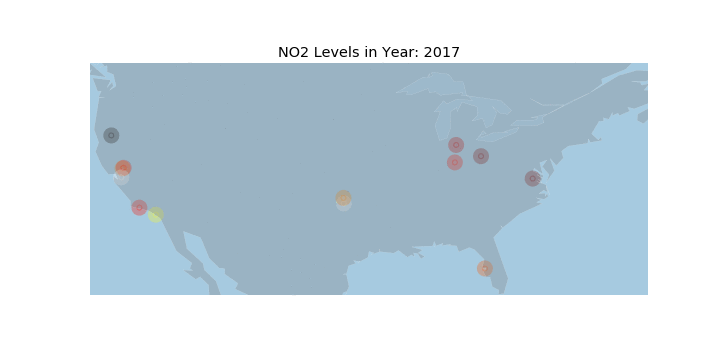

In [3]:
# Adapted from from https://www.kaggle.com/piumallick/air-pollution-analysis-on-air-quality-index
OpenAQ = open_aq.query_to_pandas_safe(no2_over_time)
fig = plt.figure(figsize=(10,5))
plt.style.use('ggplot')
ani = animation.FuncAnimation(fig,animate,list(OpenAQ['Year'].unique()), interval = 1)    
ani.save('animation.gif', writer='imagemagick', fps=1)
plt.close(1)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

*Step 4: Interactive map of average pollution levels in Colorado in 2019 (o3, co, no2, so2, and pm25)*

In [4]:
pollutants = ['o3','no2','pm25']
for i in pollutants:
    query = query_all_1pollutant_1country(i, "US")
    df_usa = open_aq.query_to_pandas(query)
    df_usa.sort_values(by=['timestamp'], inplace=True) 
    minValue = min(df_usa['value'])
    maxValue = max(df_usa['value'])
    custom_colormap = folium.StepColormap(['yellow','orange','red','black'], 
                         vmin=minValue, vmax=maxValue,
                         index=[minValue, maxValue/4,maxValue/2, 3*maxValue/4],
                        caption=i+' ppm')
    df_usa_map = folium_map(df_usa, 40,-105, 6)
    print(i+': \n')
    ICD.display(df_usa_map)

o3: 



no2: 



pm25: 



It looks like there are too few measurements at each location to plot things over time.

In [5]:
def query_all_1pollutant_1country(pollutant, country) :
    # Adapted from https://www.kaggle.com/dejavu23/openaq-from-queries-to-world-maps
    s = "SELECT *"
    f = " FROM `bigquery-public-data.openaq.global_air_quality` as globalAQ"
    w = " WHERE pollutant = '" + pollutant + "'" + \
        " AND value > 0" + " AND country = '" + country + "'" + \
        " AND EXTRACT(YEAR FROM globalAQ.timestamp) > 2010"
    q = s+f+w
    return q

query = query_all_1pollutant_1country("no2", "US")
df_usa = open_aq.query_to_pandas(query) 
value_list = ['Denver','Denver-Aurora','Durango']
denver = df_usa[df_usa.city.isin(value_list)]
denver.head(10) 

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,averaged_over_in_hours
118,Ute 3,Durango,US,no2,0.003,2019-06-18 08:00:00+00:00,ppm,AirNow,37.10258,-107.87022,1.0
120,Ute 1,Durango,US,no2,0.003,2019-06-18 08:00:00+00:00,ppm,AirNow,37.13678,-107.62863,1.0
196,Denver - CAMP - 2105,Denver-Aurora,US,no2,0.011,2019-06-18 07:00:00+00:00,ppm,AirNow,39.75110,-104.98720,1.0
198,La Casa NCORE - 4545,Denver-Aurora,US,no2,0.003,2019-06-18 07:00:00+00:00,ppm,AirNow,39.77940,-105.00523,1.0
202,Welby - 78th Ave. &,Denver-Aurora,US,no2,0.001,2019-06-18 07:00:00+00:00,ppm,AirNow,39.83920,-104.94890,1.0


Note that some functions were adapted from https://www.kaggle.com/dejavu23/openaq-from-queries-to-world-maps
 and https://www.kaggle.com/piumallick/air-pollution-analysis-on-air-quality-index.  See code comments for more detail.